In [25]:
import pandas as pd
import re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import wandb
from xgboost import XGBRegressor

In [26]:
data_path = "SoftwareEngineer_cleaned.csv"
df = pd.read_csv(data_path)
print(df.shape)
df.head()

(34012, 12)


,title,level,company,yearsofexperience,totalyearlycompensation,gender,Doctorate_Degree,Masters_Degree,Bachelors_Degree,tag,state,city
0,Software Engineer,SE 2,eBay,5.0,100000,NaN,0,0,0,NaN,CA,San Francisco
1,Software Engineer,60,Microsoft,5.0,157000,NaN,0,0,0,NaN,CA,Mountain View
2,Software Engineer,63,Microsoft,8.5,208000,NaN,0,0,0,NaN,WA,Seattle
3,Software Engineer,62,Microsoft,4.0,156000,NaN,0,0,0,NaN,WA,Seattle
4,Software Engineer,59,Microsoft,3.0,120000,NaN,0,0,0,NaN,WA,Redmond


In [27]:
headers1 = ["company", "yearsofexperience", "Doctorate_Degree", "Masters_Degree", "Bachelors_Degree", "state", "city", "tag", "gender", 'level', "totalyearlycompensation"]
cat = ["company", "state", "city", "tag", "gender", 'level']
df_clean = df[headers1]
df_clean

,company,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,state,city,tag,gender,level,totalyearlycompensation
0,eBay,5.0,0,0,0,CA,San Francisco,NaN,NaN,SE 2,100000
1,Microsoft,5.0,0,0,0,CA,Mountain View,NaN,NaN,60,157000
2,Microsoft,8.5,0,0,0,WA,Seattle,NaN,NaN,63,208000
3,Microsoft,4.0,0,0,0,WA,Seattle,NaN,NaN,62,156000
4,Microsoft,3.0,0,0,0,WA,Redmond,NaN,NaN,59,120000
...,...,...,...,...,...,...,...,...,...,...,...
34007,Google,10.0,0,0,0,WA,Seattle,Distributed Systems (Back-End),NaN,T4,327000
34008,Microsoft,2.0,0,0,0,WA,Redmond,Full Stack,NaN,62,237000
34009,MSFT,14.0,0,0,0,WA,Seattle,Full Stack,NaN,63,220000
34010,Salesforce,8.0,0,0,0,CA,San Francisco,iOS,NaN,Lead MTS,280000


In [28]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse_output=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_clean[cat]), index=df_clean.index)

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(cat)
encode_df.head()

,company_10x Genomics,company_23andMe,company_2U,company_3M,company_3m,company_7-Eleven,company_7-eleven,company_8x8,company_ABB,company_ADP,...,level_unknown,level_vice president,level_x2,level_x4,level_x5,level_x6,level_x7,level_z4,level_||,level_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df_clean = df_clean.merge(encode_df,left_index=True, right_index=True)
df_clean = df_clean.drop(cat,1)
df_clean# Merge one-hot encoded features and drop the originals
df_clean

C:\Users\pedia\AppData\Local\Temp\ipykernel_28084\1232695819.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_clean = df_clean.drop(cat,1)


,yearsofexperience,Doctorate_Degree,Masters_Degree,Bachelors_Degree,totalyearlycompensation,company_10x Genomics,company_23andMe,company_2U,company_3M,company_3m,...,level_unknown,level_vice president,level_x2,level_x4,level_x5,level_x6,level_x7,level_z4,level_||,level_nan
0,5.0,0,0,0,100000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0,0,0,157000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.5,0,0,0,208000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0,0,0,156000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0,0,0,120000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34007,10.0,0,0,0,327000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34008,2.0,0,0,0,237000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34009,14.0,0,0,0,220000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34010,8.0,0,0,0,280000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Split our preprocessed data into our features and target arrays
y = df_clean.totalyearlycompensation
X = df_clean.drop(columns=["totalyearlycompensation"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78, train_size=0.8)

In [31]:
X_train = torch.from_numpy(X_train.values).float()
y_train = torch.from_numpy(y_train.values).float()
X_test = torch.from_numpy(X_test.values).float()
y_test = torch.from_numpy(y_test.values).float()

# Gradient Boosting Algorithm

Gradient boosting is one of the most popular machine learning algorithms for tabular datasets. It is powerful enough to find any nonlinear relationship between model, target and features and has great usability that can deal with missing values, outliers, and high cardinality categorical values on features without any special treatment. I build gradient boosting trees using  XGBoost.

In [32]:
xgb = XGBRegressor(n_estimators=200, max_depth=9, eta=0.175, subsample=0.6, colsample_bytree=0.85) #play with parameters
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
             early_stopping_rounds=None, enable_categorical=False, eta=0.175,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.174999997, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [35]:
Y_pred = xgb.predict(X_test)


training_score = xgb.score(X_train, y_train)
testing_score = xgb.score(X_test, y_test)
mse = mean_absolute_percentage_error(y_test, Y_pred)
rmse = mse**.5
print(mse)
#print(rmse)


print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

0.16624752
Training Score: 0.8674901089233629
Testing Score: 0.7581048016586882


In [36]:
pred = pd.DataFrame({"Prediction": Y_pred, "Actual": y_test})
pred.reset_index(drop=True, inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(pred)

         Prediction    Actual
0     254511.390625  270000.0
1     387949.281250  395000.0
2     214197.093750  227000.0
3     157161.437500  250000.0
4     224678.640625  175000.0
5     160615.234375  130000.0
6     154812.781250  172000.0
7     221982.734375  190000.0
8     178614.984375  201000.0
9     363864.687500  439000.0
10    178311.781250  135000.0
11    588040.875000  382000.0
12    157566.078125  164000.0
13    341620.968750  280000.0
14    172214.046875  174000.0
15    247727.875000  280000.0
16    194119.265625  179000.0
17    256199.718750  237000.0
18     87557.585938   85000.0
19    318555.031250  291000.0
20    268650.593750  259000.0
21    183935.281250  165000.0
22    214482.890625  200000.0
23    361199.187500  320000.0
24    251422.468750  300000.0
25    232403.765625  215000.0
26    304634.843750  544000.0
27    251507.359375  217000.0
28    282826.687500  240000.0
29    253885.125000  430000.0
30    136642.968750  106000.0
31    179431.171875  176000.0
32    2203

In [37]:
r2 = r2_score(Y_pred, y_test)
print("R-squared score: ", r2)

R-squared score:  0.6606605279314912


## Finally i achieved R2 Score 66%


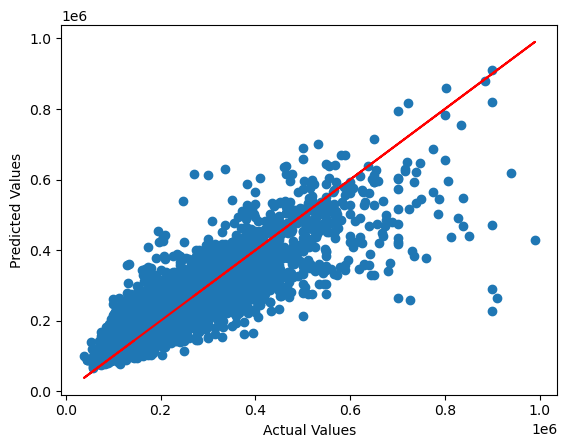

In [38]:
import matplotlib.pyplot as plt

plt.scatter(y_test, Y_pred)

# Add a line of best fit
plt.plot(y_test, y_test, color = 'red')

# Add axis labels
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Show the plot
plt.show()